In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
df = pd.read_csv(r'C:\Users\isai5\OneDrive\Documentos\Github\databases\us-software-engineer-jobs-zenrows.csv')


In [ ]:
print("--- Primeras 5 filas del dataset ---")
print(df.head())

print("\n--- Información general del dataset ---")
df.info()

print("\n--- Estadísticas descriptivas de los datos numéricos ---")
print(df.describe())

--- Primeras 5 filas del dataset ---
                                               title  \
0                                  Android Developer   
1                                      Web Developer   
2                              Sr. Android Developer   
3                           Junior Software Engineer   
4  Cloud Engineer (Software Engineer Advanced, Ex...   

                            company                    salary  rating  \
0                           Shockoe                       NaN     0.0   
1                      Denios, Inc.  $45,000 - $55,000 a year     0.0   
2               The Cervantes Group                       NaN     4.1   
3           Medical Knowledge Group                       NaN     0.0   
4  Federal Reserve Bank of New York                       NaN     4.1   

   review_count      types         location relative_time hires_needed  \
0             0  Full-time     Richmond, VA  30+ days ago          NaN   
1             0  Full-time   Louisville

In [6]:
# 3. Recortar el dataset, eliminando las filas con valores nulos en la columna 'salary'
df_cleaned = df.dropna(subset=['salary'])

# 4. Mostrar la información del nuevo dataset ya limpio
print("\n--- Información del dataset DESPUÉS de limpiar ---")
df_cleaned.info()


--- Información del dataset DESPUÉS de limpiar ---
<class 'pandas.core.frame.DataFrame'>
Index: 18103 entries, 1 to 58425
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  18103 non-null  object 
 1   company                18103 non-null  object 
 2   salary                 18103 non-null  object 
 3   rating                 18103 non-null  float64
 4   review_count           18103 non-null  int64  
 5   types                  16363 non-null  object 
 6   location               18103 non-null  object 
 7   relative_time          18103 non-null  object 
 8   hires_needed           8540 non-null   object 
 9   hires_needed_exact     13076 non-null  object 
 10  urgently_hiring        18103 non-null  bool   
 11  remote_work_model      10180 non-null  object 
 12  snippet                18103 non-null  object 
 13  dradis_job             18103 non-null  bool   
 14  link   

C:\Users\isai5\AppData\Local\Temp\ipykernel_17152\4241690224.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['salary'] = df_cleaned['salary'].apply(limpiar_salario)
C:\Users\isai5\AppData\Local\Temp\ipykernel_17152\4241690224.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.dropna(subset=['salary'], inplace=True)



Entrenando el modelo de Regresión Lineal...
¡Entrenamiento completado!

--- Resultados de la Regresión Lineal ---
Error Absoluto Medio (MAE): $31365.29
Error Cuadrático Medio (MSE): $2158781029.85
Raíz del Error Cuadrático Medio (RMSE): $46462.68
Puntaje R-cuadrado (R²): 0.32


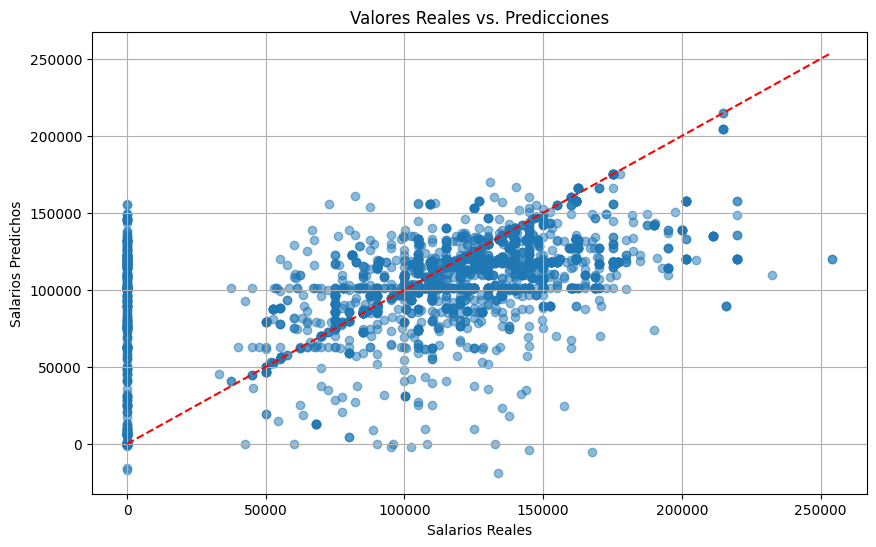

In [ ]:


# --- 1. Función de limpieza de salarios ---
def limpiar_salario(salario):
    """
    Limpia y convierte una cadena de salario a un valor numérico.
    Maneja rangos y valores por hora/anuales.
    """
    if pd.isna(salario):
        return np.nan
    
    # Convierte a minúsculas para estandarizar
    salario = str(salario).lower()
    
    # Elimina símbolos de moneda, comas y texto innecesario
    salario = salario.replace('$', '').replace(',', '').replace(' an hour', '').replace(' a year', '')

    # Maneja rangos de salario (ej: '20 - 34')
    if '-' in salario:
        partes = salario.split('-')
        try:
            # Calcula el promedio del rango
            return (float(partes[0].strip()) + float(partes[1].strip())) / 2
        except (ValueError, IndexError):
            return np.nan
    
    # Maneja valores únicos (ej: '50000')
    try:
        return float(salario.strip())
    except ValueError:
        return np.nan


# --- 3. Aplicar la función de limpieza a la columna 'salary' ---
# Ahora puedes usar la función directamente en el DataFrame original
df_cleaned['salary'] = df_cleaned['salary'].apply(limpiar_salario)

# Eliminar las filas donde el salario no se pudo convertir a un número
df_cleaned.dropna(subset=['salary'], inplace=True)

X = df_cleaned[['rating', 'review_count', 'location']]
y = df_cleaned['salary']

# Asegurarse de que el tipo de dato de la columna 'salary' sea numérico si no lo es
# Esto es importante si la columna 'salary' es de tipo 'object' y tiene símbolos de moneda o comas
# Aquí se asume que 'salary' es numérico. Si no, necesitarías un paso adicional de limpieza aquí.
# Ejemplo: y = pd.to_numeric(y.str.replace('$', '').str.replace(',', ''), errors='coerce')

# --- 3. Dividir el dataset en conjuntos de entrenamiento y prueba ---
# Usamos un 80% para entrenar y un 20% para probar el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. Preprocesamiento de datos (Pipeline) ---
# Separamos las columnas por tipo para aplicar transformaciones diferentes
numerical_features = ['rating', 'review_count']
categorical_features = ['location']

# Creamos un preprocesador que aplicará las transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# --- 5. Crear y entrenar el modelo (Pipeline) ---
# Unimos el preprocesador y el modelo en un solo Pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Entrenar el modelo con los datos de entrenamiento
print("\nEntrenando el modelo de Regresión Lineal...")
model.fit(X_train, y_train)
print("¡Entrenamiento completado!")

# --- 6. Evaluar el rendimiento del modelo ---
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Resultados de la Regresión Lineal ---")
print(f"Error Absoluto Medio (MAE): ${mae:.2f}")
print(f"Error Cuadrático Medio (MSE): ${mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): ${rmse:.2f}")
print(f"Puntaje R-cuadrado (R²): {r2:.2f}")

# --- 7. Visualizar las predicciones vs. los valores reales (Opcional) ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Valores Reales vs. Predicciones')
plt.xlabel('Salarios Reales')
plt.ylabel('Salarios Predichos')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()